In [1]:
# importing necessary libraries
import pyximport
import numpy as np
import os

from   dengo.chemistry_constants import tiny, kboltz, mh, G
import dengo.primordial_rates
import dengo.primordial_cooling

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, \
    species_registry
import dengo.primordial_rates
import dengo.primordial_cooling

import sympy
from sympy import lambdify
import matplotlib.pyplot as plt

# Building Dengo Library
`Dengo` is primarily a tool to build a solver for chemistry network. In this notebook, we will walk through how to build the C library for usage in hydrodynamical simulations like Enzo and Gamer. In this example, we will use the 9 species primordial chemistry model. And it can be generalized to more complicated chemical network

ADDED {'us_H_1'}
ADDED {'us_H2_1'}
ADDED {'us_e_0'}
{'us_H_1': array([0.01]), 'us_H2_1': array([0.01]), 'us_e_0': array([0.])}
{'us_H_1': array([0.01]), 'us_H2_1': array([0.02]), 'us_e_0': array([0.]), 'ge': array([8.26347305e+10]), 'density': array([0.03]), 'T': array([1000.])}


You have suitesparse!


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/gv0/homes/kwoksun2/dengo-merge/cookbook/umist_solver_run.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)


cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++


cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++



[CVODE ERROR]  CVode
  At t = 0 and h = 1.3093e-09, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVODE ERROR]  CVode
  At t = 0 and h = 6.54651e-10, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  tout too close to t0 to start integration.


[CVO

End in 10 iterations: 0.00000e+00 / 1.00000e+02 (1.00000e+02)


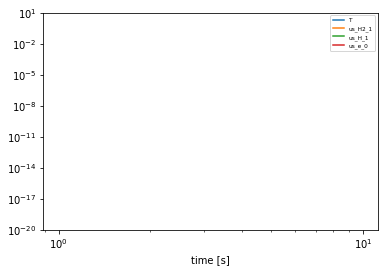

In [2]:

import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry
import dengo.umist_rates
from dengo.get_rates import setup_umist_species, setup_umist_reactions
from dengo.chemistry_constants import tiny, kboltz, mh

import os
os.environ['HDF5_DIR'] = '/home/kwoksun2/anaconda2/'

NCELLS = 1
density = 1.0e0
temperature = np.logspace(1, 3, NCELLS)
temperature[:] = 1e3
X = 1e-2

umist = ChemicalNetwork()
umist.skip_weight += ("us_e_0",)

# This defines the temperature range for the rate tables
umist.init_temperature((1e0, 1e3))

# Get UMIST rates for a bunch of species for an example network

desired_species = [
    ("H", 1),
    ("H2", 2),
    ("e-", 1)
]
added_species = set([])

for name, weight in desired_species:
    s, c, r = setup_umist_species(name, weight)
    print("ADDED", s)
    added_species.update(s)
    umist.add_collection(s, c, r)
# Add ionic species by hand, since we need correct atomic weights

s, c, r = setup_umist_reactions(added_species)
umist.add_collection(s, c, r)

tiny = 1e-10

init_array = np.ones(NCELLS) * density
init_values = dict()
init_values['us_H_1']     = init_array * X
init_values['us_H2_1']     = init_array * X
init_values['us_e_0']      = init_array * 0.0

print(init_values)
#print sorted(umist.reactions.values())

for species in umist.required_species:
    if species.name not in init_values:
        init_values[species.name] = init_array * 0.0

total_density = umist.calculate_total_density(init_values)
init_values = umist.convert_to_mass_density(init_values)
init_values['us_e_0'] = umist.calculate_free_electrons(init_values)
init_values['density'] = umist.calculate_total_density(init_values)
number_density = umist.calculate_number_density(init_values)



# set up initial temperatures values used to define ge
init_values['T'] = temperature


# calculate ge (very crudely, no H2 help here)
gamma = 5.0/3.0
init_values['ge'] = ((temperature * number_density * kboltz)
                     / (init_values['density'] * mh * (gamma - 1)))

print(init_values)


# import pdb; pdb.set_trace()

#import pdb; pdb.set_trace()

# Write the initial conditions file
umist.write_solver("umist", output_dir = ".", solver_template = "cv_omp/sundials_CVDls",ode_solver_source = "initialize_cvode_solver.C")


import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True, inplace=True)

umist_solver_run = pyximport.load_module("umist_solver_run",
                            "umist_solver_run.pyx",
                            build_inplace = True, pyxbuild_dir = "_dengo_temp")
rv, rv_int = umist_solver_run.run_umist(init_values, 1e2, niter = 1e1)

import pylab
pylab.clf()

mask = rv_int['successful']
for name in sorted(rv_int):
    if len(rv_int[name].shape) == 1:
        rv_int[name] = rv_int[name][mask]
    else:
        rv_int[name] = rv_int[name][0, mask]

skip = ('successful', 'dt', 't', 'ge')
for n, v in sorted(rv_int.items()):
    if n in skip: continue
    pylab.loglog(rv_int['t'], v, label = n)

pylab.ylim(density * 1e-20, density * 10)
pylab.xlabel("time [s]")
pylab.legend(loc='best', fontsize='xx-small')
pylab.savefig("plot.png")


In [3]:
!ls umist*

umist_solver.C
umist_solver.h
umist_solver_main.C
umist_solver_main.py
umist_solver_run.cpython-38-x86_64-linux-gnu.so
umist_solver_run.cpython-38-x86_64-linux-gnu.so.reload1
umist_solver_run.pxd
umist_solver_run.pyx
umist_solver_run.pyxbld
umist_solver_run.pyxdep
umist_tables.h5


In [4]:
pwd

'/mnt/gv0/homes/kwoksun2/dengo-merge/cookbook'

In [5]:
umist.write_solver("umist", output_dir = ".", solver_template = "cv_omp/sundials_CVDls",ode_solver_source = "initialize_cvode_solver.C")


In [6]:
umist.reactions

{}

In [7]:
setup_umist_reactions??

In [8]:
s

set()

In [9]:
c

set()

In [10]:
r

set()

In [11]:
setup_umist_species??

In [12]:
dengo.umist_rates??

In [13]:
x

NameError: name 'x' is not defined

In [23]:
h_2 = AtomicSpecies("H", 1)

In [25]:
from dengo.umist_rates import umist_rates

In [30]:
reaction_registry

{}

In [28]:
!cp ../dengo/RATE12.txt .

In [33]:
with open("RATE12.txt", "r") as f:
    lines = f.readlines()
    f.close()

In [40]:
import re
for i, line in enumerate(lines):
    reaction = re.split(":", line)
    print(reaction[2:6])
    break

['C-', 'C', 'C2', 'e-']


In [42]:
C_m0 = AtomicSpecies("C", -1)

In [45]:
C_m0.name = 'C-'

In [46]:
C_m0

Species: C-

In [51]:
#Check whether the species exists and if not, add to species registry
from dengo.reaction_classes import ChemicalSpecies, species_registry, Reaction
def _ensure_species(sp):
    # "us" => "umist species"
    sp = "us_" + sp
    sp = sp.replace("+", "p").replace("-", "m")
    if sp not in species_registry:
        i = sp.count('p')-sp.count('m')
        sp = ChemicalSpecies(sp,1.,1.,i)
    else:
        sp = species_registry[sp]
    return sp

type = reaction[1]
rA = _ensure_species(reaction[2])
rB = _ensure_species(reaction[3])
pC = _ensure_species(reaction[4])
pD = _ensure_species(reaction[5])

In [140]:
import re

def get_rate(reaction, network):
    type = reaction[1]
    rA = _ensure_species(reaction[2])
    rB = _ensure_species(reaction[3])
    pC = _ensure_species(reaction[4])
    pD = _ensure_species(reaction[5])
    a = float(reaction[9])
    b = float(reaction[10])
    g = float(reaction[11])
    T_lower = int(reaction[12])
    T_upper = int(reaction[13])
    reactants = [(1, rA), (1, rB)]
    products = [(1, pC), (1, pD)]
    
    print(reactants)
    

    temp = network.T

    if reaction[6] != '':
        pE = _ensure_species(reaction[6])
        products.append((1,pE))

    if reaction[7] != '':
        pF = _ensure_species(reaction[7])
        products.append((1,pF))

    print(products)
    print(T_lower, T_upper)
    
    if np.all(T_lower <= temp) and np.all(temp <= T_upper):
        
        if type == 'CP':
            rate = lambda network: a # rate coefficient with units 1/s
            units = "1/s"
            #return rate, units
        elif type == 'CR':
            rate = 0.0
            units = ''
            #return rate, units
        else:
            rate = lambda network: a*(network.T**b)*(np.exp(-g / network.T)) # rate coefficient with units cm^3 / s
            units = "cm^3 / s"
            #return rate, units
        return Reaction("%s_plus_%s" % (rA.name, rB.name), rate, reactants, products)
    else:
        rate = 0
        units = ''
        return rate, units



def umist_rates(species, network):
    r1 = species.name
    if r1.startswith("us_"):
        r1 = r1[3:]
        r1 = r1.replace("p", "+").replace("m", "-")
    with open("RATE12.txt", "r") as f:
        lines = f.readlines()
        f.close()
    
    c = 0
    for i,line in enumerate(lines):
        reaction = re.split(":", line)
        if (reaction[2]==r1 or reaction[3]==r1 or reaction[4]==r1 or reaction[5]==r1):
            get_rate(reaction, network)
            c += 1

In [141]:
umist.init_temperature(T_bounds = (10, 40999.0) )
get_rate(reaction, umist)

[(1, Species: us_Cm), (1, Species: us_C)]
[(1, Species: us_C2), (1, Species: us_em)]
10 41000


us_Cm_plus_us_C : 1*us_Cm + 1*us_C => 1*us_C2 + 1*us_em

In [142]:
Cm = species_registry['us_Cm']
x = umist_rates(Cm, umist)

[(1, Species: us_Cm), (1, Species: us_C)]
[(1, Species: us_C2), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_CH2)]
[(1, Species: us_C2H2), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_CH)]
[(1, Species: us_C2H), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_CO2)]
[(1, Species: us_CO), (1, Species: us_CO), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_H2O)]
[(1, Species: us_H2CO), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_N)]
[(1, Species: us_CN), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_NH)]
[(1, Species: us_HCN), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_O2)]
[(1, Species: us_CO2), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_O)]
[(1, Species: us_CO), (1, Species: us_em)]
10 41000
[(1, Species: us_Cm), (1, Species: us_OH)]
[(1, Species: us_HCO), (1, Species: us_em)]
10 41000
[(1, Species: us_H2),

In [143]:
reaction_registry

{'us_Cm_plus_us_C': us_Cm_plus_us_C : 1*us_Cm + 1*us_C => 1*us_C2 + 1*us_em,
 'us_Cm_plus_us_CH2': us_Cm_plus_us_CH2 : 1*us_Cm + 1*us_CH2 => 1*us_C2H2 + 1*us_em,
 'us_Cm_plus_us_CH': us_Cm_plus_us_CH : 1*us_Cm + 1*us_CH => 1*us_C2H + 1*us_em,
 'us_Cm_plus_us_CO2': us_Cm_plus_us_CO2 : 1*us_Cm + 1*us_CO2 => 1*us_CO + 1*us_CO + 1*us_em,
 'us_Cm_plus_us_H2O': us_Cm_plus_us_H2O : 1*us_Cm + 1*us_H2O => 1*us_H2CO + 1*us_em,
 'us_Cm_plus_us_N': us_Cm_plus_us_N : 1*us_Cm + 1*us_N => 1*us_CN + 1*us_em,
 'us_Cm_plus_us_NH': us_Cm_plus_us_NH : 1*us_Cm + 1*us_NH => 1*us_HCN + 1*us_em,
 'us_Cm_plus_us_O2': us_Cm_plus_us_O2 : 1*us_Cm + 1*us_O2 => 1*us_CO + 1*us_Om,
 'us_Cm_plus_us_O': us_Cm_plus_us_O : 1*us_Cm + 1*us_O => 1*us_CO + 1*us_em,
 'us_Cm_plus_us_OH': us_Cm_plus_us_OH : 1*us_Cm + 1*us_OH => 1*us_HCO + 1*us_em,
 'us_H2_plus_us_Cm': us_H2_plus_us_Cm : 1*us_H2 + 1*us_Cm => 1*us_CH2 + 1*us_em,
 'us_H_plus_us_Cm': us_H_plus_us_Cm : 1*us_H + 1*us_Cm => 1*us_CH + 1*us_em,
 'us_Cm_plus_us_CRPHOT': 

In [123]:
hco = species_registry['us_HCO']

In [125]:
hco.weight

1.0

In [136]:
hco.original_name = "HCO2"

In [137]:
hco.find_constituent()

In [138]:
hco.find_constituent??

Signature: hco.find_constituent()
Source:   
    def find_constituent(self):
        """find elements based on its name
        return: total weight
        """
        self._edict = {}
        name = self.original_name
        split = re.findall("\d+|\D+[a-z]|\D", name)
        for s in split:
            if s.isalpha():
                _ele = s
            if s.isnumeric():
                self.add_to_dict(_ele, int(s)-1)
            else:
                self.add_to_dict(_ele, 1)
        self.elements = self._edict
File:      ~/dengo-merge/dengo/reaction_classes.py
Type:      method


In [139]:
hco.elements

{'H': 1, 'C': 1, 'O': 2}